In [1]:
import scipy
import matplotlib
import numpy as np
import math
import pylab
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import colorbar
from matplotlib.patches import Ellipse
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterExponent
from matplotlib.ticker import LogLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FixedLocator
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from astropy.table import Table, vstack, join
from astropy.io import ascii, fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from collections import Counter
from matplotlib.lines import Line2D
import lmfit
from sklearn.linear_model import LinearRegression
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor #연속형 데이터 처리
from sklearn.metrics import mean_squared_error
pd.options.mode.copy_on_write = True
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [9]:
## Common function for reading files and preprocessing data
def read_fits_and_cut(input_file_name):
    table = Table.read(input_file_name)
    df = table.to_pandas()
    df['id'] = df['id'].astype(str)
    for column in df.columns:
        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
            df[column] = df[column].str.decode('utf-8')
    df['g0'] = df['gpsf'] - df['a_g']
    df['i0'] = df['ipsf'] - df['a_i']
    df['n0'] = df['npsf'] - df['a_n']
    df['MGH'] = df['MGFE'] + df['FEH']
    #df = df[(-0.0 < df['MGFEERR']) & (df['MGFEERR'] < 0.5)] #or df = df[(-0.80 <= df['MGFE']) & (df['MGFE'] < 1.20)]
    return df

def read_fits_and_cut_plus(input_file_name):
    df = pd.read_csv(input_file_name)
    df['id'] = df['id'].astype(str)
    df.drop(['MASK','SLIT','B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
            'AGE','TEFFERR','LOGGERR','ALPHAFE', 'ALPHAFEERR','SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR'], axis=1, inplace=True)
    for column in df.columns:
        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
            df[column] = df[column].str.decode('utf-8')
    df = df[(-0.0 < df['MGFEERR']) & (df['MGFEERR'] < 0.5)]
    return df
    
def read_hsc(input_file_name):
    data = ascii.read(input_file_name,
        names=['id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr',
        'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n'])
    df = data.to_pandas()
    df['id'] = df['id'].astype(str)
    for column in df.columns:
        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
            df[column] = df[column].str.decode('utf-8')
    df['g0'] = df['gpsf'] - df['a_g']
    df['i0'] = df['ipsf'] - df['a_i']
    df['n0'] = df['npsf'] - df['a_n']
    return df

def read_hsc_members(input_file_name):
    df = pd.read_csv(input_file_name)
    df['id'] = df['id'].astype(str)
    for column in df.columns:
        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
            df[column] = df[column].str.decode('utf-8')
    return df

In [10]:
## Read HSC-DEIMOS files
fnx = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Fornax_DEIMOS_Evan_Lauren.csv')
scl = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Sculptor_DEIMOS_Evan_Lauren.csv')
umi = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Ursaminor_DEIMOS_Evan_Lauren.csv')
dra = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Draco_DEIMOS_Evan_Lauren.csv')
print(f'len(fnx) = {len(fnx)}') #628 -> 360
print(f'len(scl) = {len(scl)}') #599 -> 361
print(f'len(umi) = {len(umi)}') #384 -> 108
print(f'len(dra) = {len(dra)}') #346 -> 130

## Read whole HSC data
hsc_fnx = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/fornax_tpall3e_g24_radec_members_cut.csv')
hsc_scl = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/sculptor_tpall3e_g24_radec_members_cut.csv')
hsc_umi = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/ursaminor_tpall3e_g24_radec_members_cut.csv')
hsc_dra = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/draco_tpall3e_g24_radec_members_cut.csv')
print(f'len(hsc_fnx) = {len(hsc_fnx)}') #49704
print(f'len(hsc_scl) = {len(hsc_scl)}') #10360
print(f'len(hsc_umi) = {len(hsc_umi)}') #5891
print(f'len(hsc_dra) = {len(hsc_dra)}') #5430

len(fnx) = 360
len(scl) = 361
len(umi) = 108
len(dra) = 130
len(hsc_fnx) = 49704
len(hsc_scl) = 10360
len(hsc_umi) = 5891
len(hsc_dra) = 5430


In [11]:
# Define the distance modulus for each dataset from McConnachie (2012)
dm_values = {
    'fnx': 20.84,
    'scl': 19.67,
    'umi': 19.4,
    'dra': 19.4
}

# Define the datasets
datasets = {
    'fnx': [fnx, hsc_fnx],
    'scl': [scl, hsc_scl],
    'umi': [umi, hsc_umi],
    'dra': [dra, hsc_dra]
}

# Apply the distance modulus correction and store as G0
for key, dataset_list in datasets.items():
    dm = dm_values[key]
    for dataset in dataset_list:
        dataset['Mg0'] = dataset['g0'] - dm
        dataset['Mi0'] = dataset['i0'] - dm
        dataset['Mn0'] = dataset['n0'] - dm

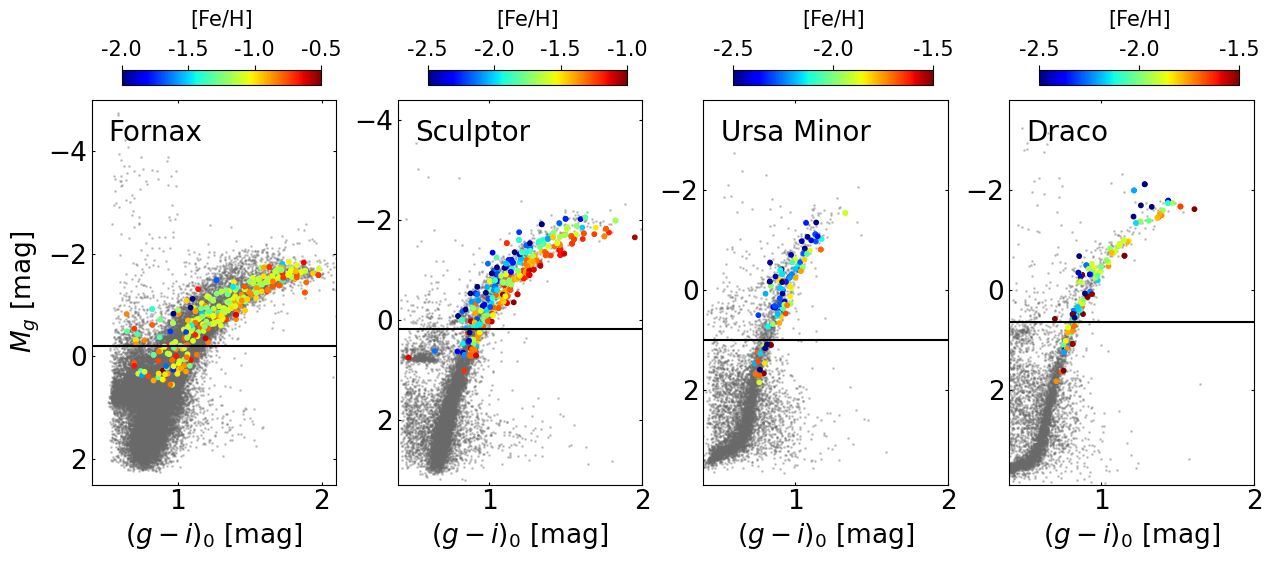

In [12]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5), gridspec_kw={'wspace':0.25})
s_deimos = 10 ; s_hsc = 1 ; alpha = 0.3

# Fornax
ymin = -5 ; ymax = 2.5
ax0.scatter(hsc_fnx['g0'] - hsc_fnx['i0'], hsc_fnx['Mg0'], marker='o', s=s_hsc, color='dimgray', alpha=alpha)
im = ax0.scatter(fnx['g0'] - fnx['i0'], fnx['Mg0'], marker='o', s=s_deimos, c=fnx['FEH'], cmap='jet', vmin=-2, vmax=-0.5)
ax0.set_xlim([0.4, 2.1])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('$(g - i)_0$ [mag]', size=19)
ax0.set_ylabel('$M_g$ [mag]', size=19)
g0_max = -0.20
ax0.axhline(g0_max, 0, 1, color='k')
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=2.5, labelsize=19)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=19)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=2.5, labelsize=19)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=19)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.03, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.03])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('[Fe/H]', size=15, labelpad=10, loc='center')
cbar.ax.set_xticks([-2.0, -1.5, -1.0, -0.5])
cbar.ax.set_xticklabels(['-2.0', '-1.5', '-1.0', '-0.5'])
ax0.text(0.07, 0.95, 'Fornax', ha='left', va='top', transform=ax0.transAxes, size=20)

# Sculptor
ymin = -4.4 ; ymax = 3.3
ax1.scatter(hsc_scl['g0'] - hsc_scl['i0'], hsc_scl['Mg0'], marker='o', s=s_hsc, color='dimgray', alpha=alpha)
im = ax1.scatter(scl['g0'] - scl['i0'], scl['Mg0'], marker='o', s=s_deimos, c=scl['FEH'], cmap='jet', vmin=-2.5, vmax=-1.0)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('$(g - i)_0$ [mag]', size=19)
ax1.set_ylabel('')
g0_max = 0.18
ax1.axhline(g0_max, 0, 1, color='k')
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=2.5, labelsize=19)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=19)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=2.5, labelsize=19)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=19)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.03, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.03])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('[Fe/H]', size=15, labelpad=10, loc='center')
cbar.ax.set_xticks([-2.5, -2.0, -1.5, -1.0])
cbar.ax.set_xticklabels(['-2.5', '-2.0', '-1.5', '-1.0'])
ax1.text(0.07, 0.95, 'Sculptor', ha='left', va='top', transform=ax1.transAxes, size=20)

# Ursa Minor
ymin = -3.8 ; ymax = 3.9
ax2.scatter(hsc_umi['g0'] - hsc_umi['i0'], hsc_umi['Mg0'], marker='o', s=s_hsc, color='dimgray', alpha=alpha)
im = ax2.scatter(umi['g0'] - umi['i0'], umi['Mg0'], marker='o', s=s_deimos, c=umi['FEH'], cmap='jet', vmin=-2.5, vmax=-1.5)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('$(g - i)_0$ [mag]', size=19)
ax2.set_ylabel('')
g0_max = 1.00
ax2.axhline(g0_max, 0, 1, color='k')
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=2.5, labelsize=19)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=19)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=2.5, labelsize=19)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=19)
cax = fig.add_axes([ax2.get_position().x0+0.02, ax2.get_position().y1+0.03, ax2.get_position().x1-ax2.get_position().x0-0.03, 0.03])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('[Fe/H]', size=15, labelpad=10, loc='center')
cbar.ax.set_xticks([-2.5, -2.0, -1.5])
cbar.ax.set_xticklabels(['-2.5', '-2.0', '-1.5'])
ax2.text(0.07, 0.95, 'Ursa Minor', ha='left', va='top', transform=ax2.transAxes, size=20)

# Draco
ymin = -3.8 ; ymax = 3.9
ax3.scatter(hsc_dra['g0'] - hsc_dra['i0'], hsc_dra['Mg0'], marker='o', s=s_hsc, color='dimgray', alpha=alpha)
im = ax3.scatter(dra['g0'] - dra['i0'], dra['Mg0'], marker='o', s=s_deimos, c=dra['FEH'], cmap='jet', vmin=-2.5, vmax=-1.5)
ax3.set_xlim([0.4, 2])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel('$(g - i)_0$ [mag]', size=19)
ax3.set_ylabel('')
g0_max = 0.65
ax3.axhline(g0_max, 0, 1, color='k')
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=2.5, labelsize=19)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=19)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=2.5, labelsize=19)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=19)
cax = fig.add_axes([ax3.get_position().x0+0.02, ax3.get_position().y1+0.03, ax3.get_position().x1-ax3.get_position().x0-0.03, 0.03])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('[Fe/H]', size=15, labelpad=10, loc='center')
cbar.ax.set_xticks([-2.5, -2.0, -1.5])
cbar.ax.set_xticklabels(['-2.5', '-2.0', '-1.5'])
ax3.text(0.07, 0.95, 'Draco', ha='left', va='top', transform=ax3.transAxes, size=20)

plt.savefig('Fornax_Sculptor_Ursaminor_Draco_HSC_DEIMOS_mag_cut.png', bbox_inches='tight')

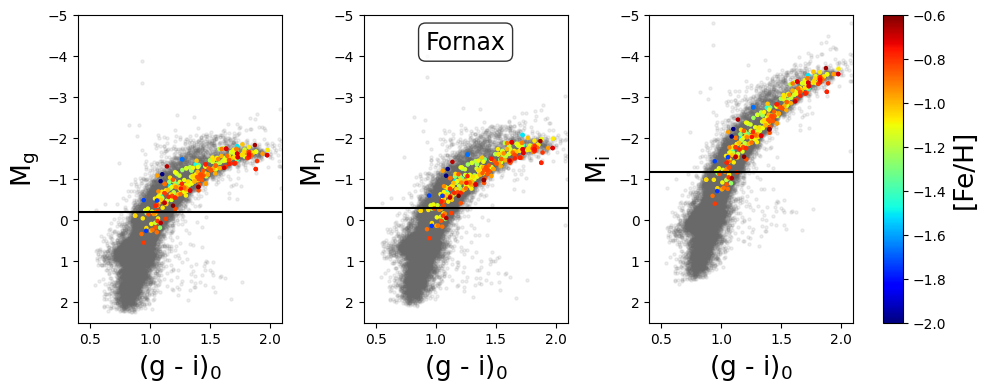

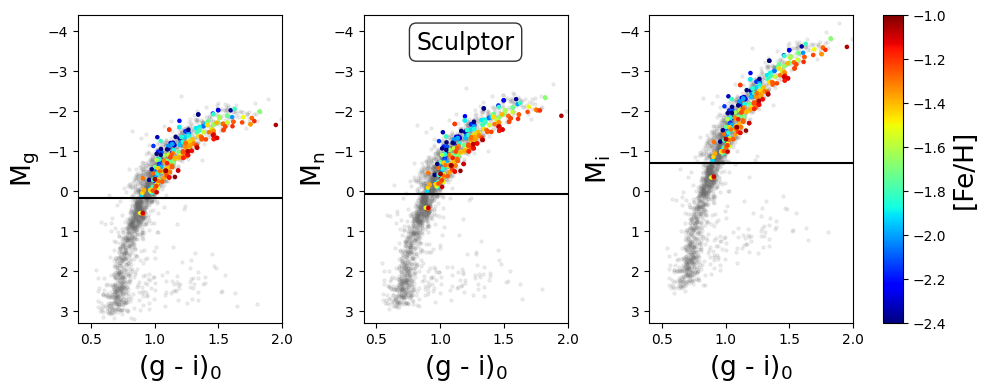

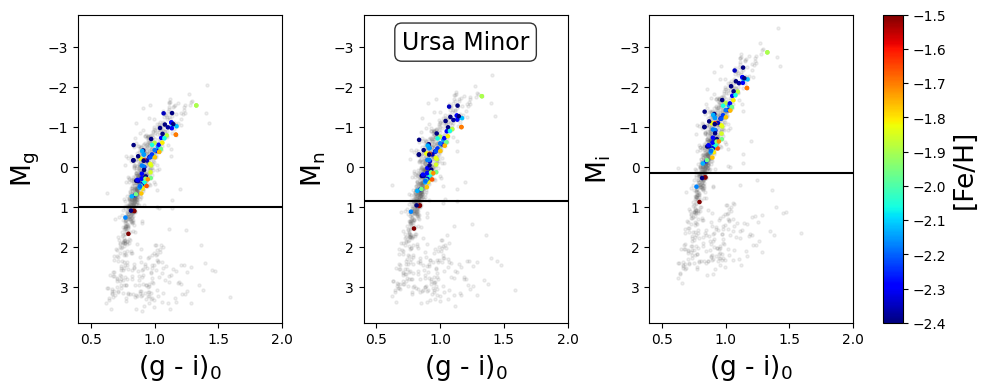

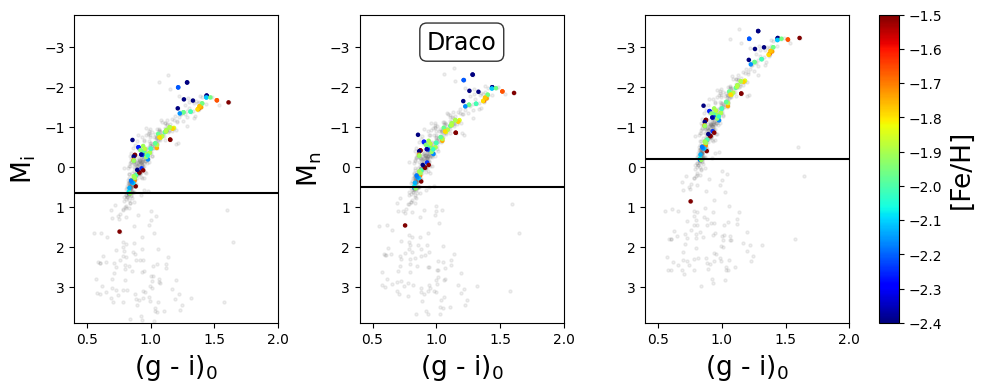

In [29]:
# Fornax
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10,4), gridspec_kw={'wspace':0.4})
ymin = -5 ; ymax = 2.5 ; s = 5

ax0.scatter(hsc_fnx['g0'] - hsc_fnx['i0'], hsc_fnx['g0'], marker='o', s=s, color='dimgray', alpha=0.1)
im = ax0.scatter(fnx['g0'] - fnx['i0'], fnx['g0'], marker='o', s=s, c=fnx['FEH'], cmap='jet', vmin=-2, vmax=-0.6)
ax0.set_xlim([0.4, 2.1])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('(g - i)$_{0}$', size=19)
ax0.set_ylabel(r'M$_\mathrm{g}$', size=19)
g0_max = -0.20
ax0.axhline(g0_max, 0, 1, color='k')

ax1.scatter(hsc_fnx['g0'] - hsc_fnx['i0'], hsc_fnx['n0'], marker='o', s=s, color='dimgray', alpha=0.1)
ax1.scatter(fnx['g0'] - fnx['i0'], fnx['n0'], marker='o', s=s, c=fnx['FEH'], cmap='jet', vmin=-2, vmax=-0.6)
ax1.set_xlim([0.4, 2.1])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('(g - i)$_{0}$', size=19)
ax1.set_ylabel(r'M$_\mathrm{n}$', size=19)
n0_max = -0.30
ax1.axhline(n0_max, 0, 1, color='k')
ax1.text(0.5, 0.95, 'Fornax', ha='center', va='top', transform=ax1.transAxes, size=17, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2.scatter(hsc_fnx['g0'] - hsc_fnx['i0'], hsc_fnx['i0'], marker='o', s=s, color='dimgray', alpha=0.1)
ax2.scatter(fnx['g0'] - fnx['i0'], fnx['i0'], marker='o', s=s, c=fnx['FEH'], cmap='jet', vmin=-2, vmax=-0.6)
ax2.set_xlim([0.4, 2.1])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('(g - i)$_{0}$', size=19)
ax2.set_ylabel(r'M$_\mathrm{i}$', size=19)
i0_max = -1.18
ax2.axhline(i0_max, 0, 1, color='k')
cax = fig.add_axes([ax2.get_position().x1+0.03, ax2.get_position().y0, 0.02, ax2.get_position().height])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('[Fe/H]', size=19)
plt.savefig('Fornax_HSC_DEIMOS_mag_cut.png', bbox_inches='tight')



# Sculptor
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10,4), gridspec_kw={'wspace':0.4})
ymin = -4.4 ; ymax = 3.3 ; s = 5

ax0.scatter(hsc_scl['g0'] - hsc_scl['i0'], hsc_scl['g0'], marker='o', s=s, color='dimgray', alpha=0.1)
im = ax0.scatter(scl['g0'] - scl['i0'], scl['g0'], marker='o', s=s, c=scl['FEH'], cmap='jet', vmin=-2.4, vmax=-1.0)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('(g - i)$_{0}$', size=19)
ax0.set_ylabel(r'M$_\mathrm{g}$', size=19)
g0_max = 0.18
ax0.axhline(g0_max, 0, 1, color='k')

ax1.scatter(hsc_scl['g0'] - hsc_scl['i0'], hsc_scl['n0'], marker='o', s=s, color='dimgray', alpha=0.1)
ax1.scatter(scl['g0'] - scl['i0'], scl['n0'], marker='o', s=s, c=scl['FEH'], cmap='jet', vmin=-2.4, vmax=-1.0)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('(g - i)$_{0}$', size=19)
ax1.set_ylabel(r'M$_\mathrm{n}$', size=19)
n0_max = 0.08
ax1.axhline(n0_max, 0, 1, color='k')
ax1.text(0.5, 0.95, 'Sculptor', ha='center', va='top', transform=ax1.transAxes, size=17, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2.scatter(hsc_scl['g0'] - hsc_scl['i0'], hsc_scl['i0'], marker='o', s=s, color='dimgray', alpha=0.1)
ax2.scatter(scl['g0'] - scl['i0'], scl['i0'], marker='o', s=s, c=scl['FEH'], cmap='jet', vmin=-2.4, vmax=-1.0)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('(g - i)$_{0}$', size=19)
ax2.set_ylabel(r'M$_\mathrm{i}$', size=19)
i0_max = -0.70
ax2.axhline(i0_max, 0, 1, color='k')
cax = fig.add_axes([ax2.get_position().x1+0.03, ax2.get_position().y0, 0.02, ax2.get_position().height])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('[Fe/H]', size=19)
plt.savefig('Sculptor_HSC_DEIMOS_mag_cut.png', bbox_inches='tight')



# Ursa Minor
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10,4), gridspec_kw={'wspace':0.4})
ymin = -3.8 ; ymax = 3.9 ; s=5

ax0.scatter(hsc_umi['g0'] - hsc_umi['i0'], hsc_umi['g0'], marker='o', s=s, color='dimgray', alpha=0.1)
im = ax0.scatter(umi['g0'] - umi['i0'], umi['g0'], marker='o', s=s, c=umi['FEH'], cmap='jet', vmin=-2.4, vmax=-1.5)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('(g - i)$_{0}$', size=19)
ax0.set_ylabel(r'M$_\mathrm{g}$', size=19)
g0_max = 1.00
ax0.axhline(g0_max, 0, 1, color='k')

ax1.scatter(hsc_umi['g0'] - hsc_umi['i0'], hsc_umi['n0'], marker='o', s=s, color='dimgray', alpha=0.1)
ax1.scatter(umi['g0'] - umi['i0'], umi['n0'], marker='o', s=s, c=umi['FEH'], cmap='jet', vmin=-2.4, vmax=-1.5)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('(g - i)$_{0}$', size=19)
ax1.set_ylabel(r'M$_\mathrm{n}$', size=19)
n0_max = 0.85
ax1.axhline(n0_max, 0, 1, color='k')
ax1.text(0.5, 0.95, 'Ursa Minor', ha='center', va='top', transform=ax1.transAxes, size=17, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2.scatter(hsc_umi['g0'] - hsc_umi['i0'], hsc_umi['i0'], marker='o', s=s, color='dimgray', alpha=0.1)
ax2.scatter(umi['g0'] - umi['i0'], umi['i0'], marker='o', s=s, c=umi['FEH'], cmap='jet', vmin=-2.4, vmax=-1.5)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('(g - i)$_{0}$', size=19)
ax2.set_ylabel(r'M$_\mathrm{i}$', size=19)
i0_max = 0.15
ax2.axhline(i0_max, 0, 1, color='k')
cax = fig.add_axes([ax2.get_position().x1+0.03, ax2.get_position().y0, 0.02, ax2.get_position().height])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('[Fe/H]', size=19)
plt.savefig('Ursaminor_HSC_DEIMOS_mag_cut.png', bbox_inches='tight')



# Draco
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10,4), gridspec_kw={'wspace':0.4})
ymin = -3.8 ; ymax = 3.9 ; s=5

ax0.scatter(hsc_dra['g0'] - hsc_dra['i0'], hsc_dra['g0'], marker='o', s=s, color='dimgray', alpha=0.1)
im = ax0.scatter(dra['g0'] - dra['i0'], dra['g0'], marker='o', s=s, c=dra['FEH'], cmap='jet', vmin=-2.4, vmax=-1.5)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('(g - i)$_{0}$', size=19)
ax0.set_ylabel(r'M$_\mathrm{g}$', size=19)
g0_max = 0.65
ax0.axhline(g0_max, 0, 1, color='k')

ax1.scatter(hsc_dra['g0'] - hsc_dra['i0'], hsc_dra['n0'], marker='o', s=s, color='dimgray', alpha=0.1)
ax1.scatter(dra['g0'] - dra['i0'], dra['n0'], marker='o', s=s, c=dra['FEH'], cmap='jet', vmin=-2.4, vmax=-1.5)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('(g - i)$_{0}$', size=19)
ax1.set_ylabel(r'M$_\mathrm{n}$', size=19)
n0_max = 0.50
ax1.axhline(n0_max, 0, 1, color='k')
ax1.text(0.5, 0.95, 'Draco', ha='center', va='top', transform=ax1.transAxes, size=17, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2.scatter(hsc_dra['g0'] - hsc_dra['i0'], hsc_dra['i0'], marker='o', s=s, color='dimgray', alpha=0.1)
ax2.scatter(dra['g0'] - dra['i0'], dra['i0'], marker='o', s=s, c=dra['FEH'], cmap='jet', vmin=-2.4, vmax=-1.5)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('(g - i)$_{0}$', size=19)
ax0.set_ylabel(r'M$_\mathrm{i}$', size=19)
i0_max = -0.20
ax2.axhline(i0_max, 0, 1, color='k')
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3.5, labelsize=19)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=3, labelsize=19)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3.5, labelsize=19)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=3, labelsize=19)
cax = fig.add_axes([ax2.get_position().x1+0.03, ax2.get_position().y0, 0.02, ax2.get_position().height])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('[Fe/H]', size=19)
plt.savefig('Draco_HSC_DEIMOS_mag_cut.png', bbox_inches='tight')

len(fnx_mag) = 308 -> 283
len(hsc_fnx_mag) = 23089 -> 7251


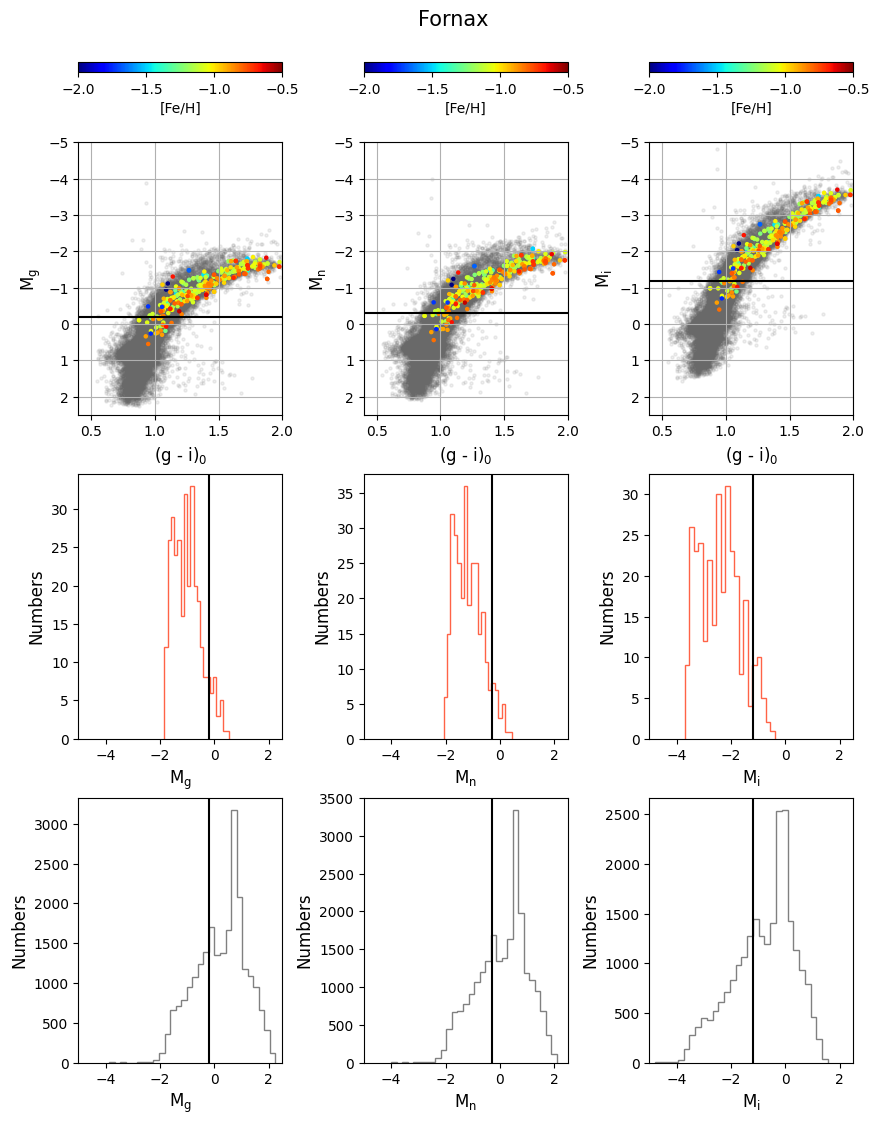

In [28]:
# Fornax

#fnx_g0_i0 = fnx['g0']-fnx['i0']
#print(min(fnx_g0_i0))
#fnx_g0_sorted = fnx.sort_values(by='g0', ascending=False).head(40)
#fnx_n0_sorted = fnx.sort_values(by='n0', ascending=False).head(40)
#fnx_i0_sorted = fnx.sort_values(by='i0', ascending=False).head(40)
#result = fnx_g0_sorted[['g0']].reset_index(drop=True)
#result['n0'] = fnx_n0_sorted['n0'].reset_index(drop=True)
#result['i0'] = fnx_i0_sorted['i0'].reset_index(drop=True)
#print(result)

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5), (ax6, ax7, ax8)) = plt.subplots(nrows=3, ncols=3, figsize=(10,13), gridspec_kw={'wspace':0.4, 'height_ratios': [1, 0.75, 0.75]})
ymin = -5 ; ymax = 2.5 ; s = 5
fig.suptitle('Fornax', size=15, y=0.92)

ax0.scatter(hsc_fnx['g0'] - hsc_fnx['i0'], hsc_fnx['g0'], marker='o', s=s, color='dimgray', alpha=0.1)
im = ax0.scatter(fnx['g0'] - fnx['i0'], fnx['g0'], marker='o', s=s, c=fnx['FEH'], cmap='jet', vmin=-2, vmax=-0.5)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('(g - i)$_{0}$', size=12)
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.grid()
g0_max = -0.20
ax0.axhline(g0_max, 0, 1, color='k')
divider = make_axes_locatable(ax0)
cax = divider.new_vertical(size = '4%', pad = 0.7)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('[Fe/H]')

ax1.scatter(hsc_fnx['g0'] - hsc_fnx['i0'], hsc_fnx['n0'], marker='o', s=s, color='dimgray', alpha=0.1)
im = ax1.scatter(fnx['g0'] - fnx['i0'], fnx['n0'], marker='o', s=s, c=fnx['FEH'], cmap='jet', vmin=-2, vmax=-0.5)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('(g - i)$_{0}$', size=12)
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.grid()
n0_max = -0.30
ax1.axhline(n0_max, 0, 1, color='k')
divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size = '4%', pad = 0.7)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('[Fe/H]')

ax2.scatter(hsc_fnx['g0'] - hsc_fnx['i0'], hsc_fnx['i0'], marker='o', s=s, color='dimgray', alpha=0.1)
im = ax2.scatter(fnx['g0'] - fnx['i0'], fnx['i0'], marker='o', s=s, c=fnx['FEH'], cmap='jet', vmin=-2, vmax=-0.5)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('(g - i)$_{0}$', size=12)
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.grid()
i0_max = -1.18
ax2.axhline(i0_max, 0, 1, color='k')
divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size = '4%', pad = 0.7)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('[Fe/H]')

ax3.hist(fnx['g0'], bins=20, histtype='step', linestyle='solid', color='tomato', linewidth=1)
ax3.set_xlabel(r'M$_\mathrm{g}$', size=12)
ax3.set_ylabel('Numbers', size=12)
ax3.set_xlim([ymin, ymax])
ax3.axvline(g0_max, 0, 1, color='k')

ax4.hist(fnx['n0'], bins=20, histtype='step', linestyle='solid', color='tomato', linewidth=1)
ax4.set_xlabel(r'M$_\mathrm{n}$', size=12)
ax4.set_ylabel('Numbers', size=12)
ax4.set_xlim([ymin, ymax])
ax4.axvline(n0_max, 0, 1, color='k')

ax5.hist(fnx['i0'], bins=20, histtype='step', linestyle='solid', color='tomato', linewidth=1)
ax5.set_xlabel(r'M$_\mathrm{i}$', size=12)
ax5.set_ylabel('Numbers', size=12)
ax5.set_xlim([ymin, ymax])
ax5.axvline(i0_max, 0, 1, color='k')

ax6.hist(hsc_fnx['g0'], bins=30, histtype='step', linestyle='solid', color='gray', linewidth=1)
ax6.set_xlabel(r'M$_\mathrm{g}$', size=12)
ax6.set_ylabel('Numbers', size=12)
ax6.set_ylabel('Numbers', size=12)
ax6.set_xlim([ymin, ymax])
ax6.axvline(g0_max, 0, 1, color='k')

ax7.hist(hsc_fnx['n0'], bins=30, histtype='step', linestyle='solid', color='gray', linewidth=1)
ax7.set_xlabel(r'M$_\mathrm{n}$', size=12)
ax7.set_ylabel('Numbers', size=12)
ax7.set_xlim([ymin, ymax])
ax7.axvline(n0_max, 0, 1, color='k')

ax8.hist(hsc_fnx['i0'], bins=30, histtype='step', linestyle='solid', color='gray', linewidth=1)
ax8.set_xlabel(r'M$_\mathrm{i}$', size=12)
ax8.set_ylabel('Numbers', size=12)
ax8.set_xlim([ymin, ymax])
ax8.axvline(i0_max, 0, 1, color='k')

plt.savefig('Fornax_HSC_DEIMOS_mag_cut_maghisto.png', bbox_inches='tight')

# Cut the mag ragnes #DEIMOS 범위에 맞게 HSC를 다 cut하기. It's for more solid results
xmin, xmax = 0.4, 2
g0_max = -0.20 ; n0_max = -0.30 ; i0_max = -1.18
fnx_mag = fnx[(xmin < fnx['g0']-fnx['i0']) & (fnx['g0']-fnx['i0'] < xmax) & (fnx['g0'] < g0_max) & (fnx['n0'] < n0_max) & (fnx['i0'] < i0_max)]
print('len(fnx_mag) =', len(fnx), '->', len(fnx_mag)) #308 -> 283
hsc_fnx_mag = hsc_fnx[(xmin < hsc_fnx['g0']-hsc_fnx['i0']) & (hsc_fnx['g0']-hsc_fnx['i0'] < xmax) & (hsc_fnx['g0'] < g0_max) & (hsc_fnx['n0'] < n0_max) & (hsc_fnx['i0'] < i0_max)]
print('len(hsc_fnx_mag) =', len(hsc_fnx), '->', len(hsc_fnx_mag)) #23089 -> 7251

len(scl_mag) = 283 -> 280
len(hsc_scl_mag) = 2137 -> 1132


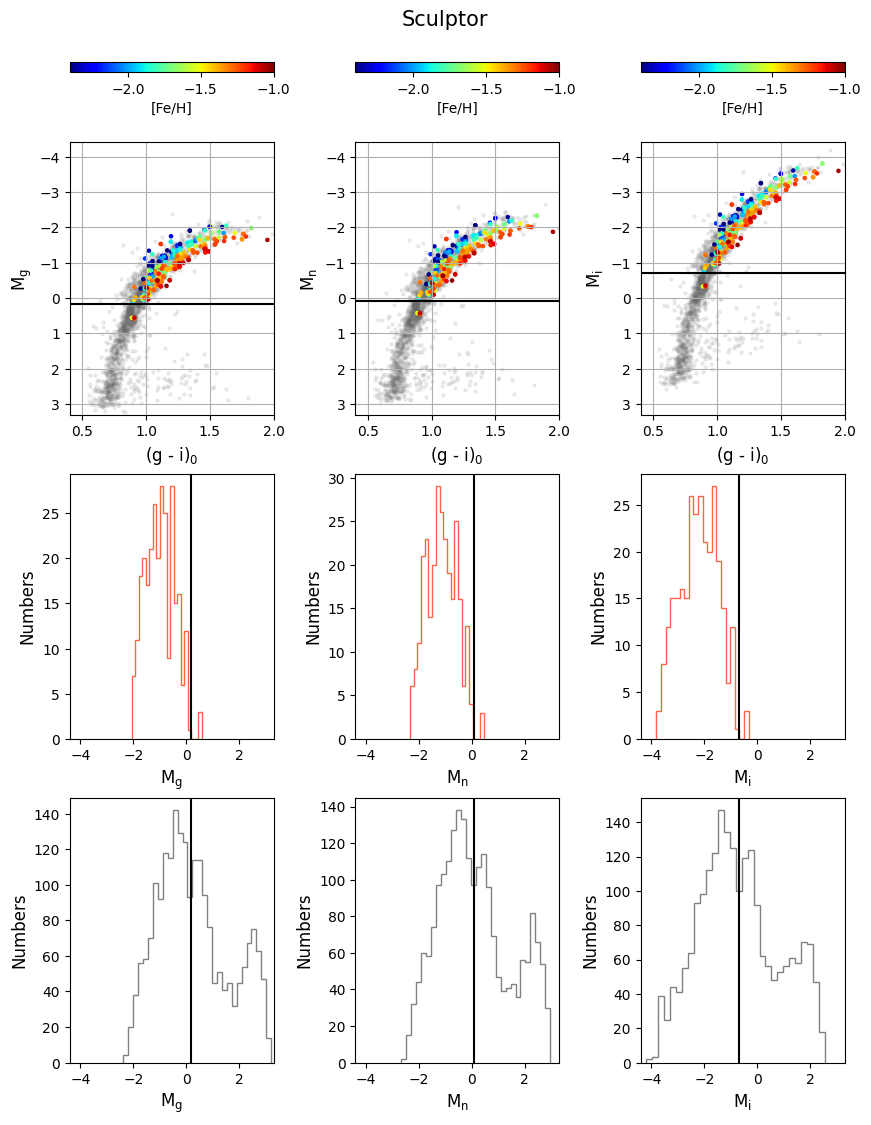

In [17]:
# Sculptor

#scl_g0_i0 = scl['g0']-scl['i0']
#print(min(scl_g0_i0))
#scl_g0_sorted = scl.sort_values(by='g0', ascending=False).head(40)
#scl_n0_sorted = scl.sort_values(by='n0', ascending=False).head(40)
#scl_i0_sorted = scl.sort_values(by='i0', ascending=False).head(40)
#result = scl_g0_sorted[['g0']].reset_index(drop=True)
#result['n0'] = scl_n0_sorted['n0'].reset_index(drop=True)
#result['i0'] = scl_i0_sorted['i0'].reset_index(drop=True)
#print(result)

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5), (ax6, ax7, ax8)) = plt.subplots(nrows=3, ncols=3, figsize=(10,13), gridspec_kw={'wspace':0.4, 'height_ratios': [1, 0.75, 0.75]})
ymin = -4.4 ; ymax = 3.3 ; s = 5
fig.suptitle('Sculptor', size=15, y=0.92)

ax0.scatter(hsc_scl['g0'] - hsc_scl['i0'], hsc_scl['g0'], marker='o', s=s, color='dimgray', alpha=0.1)
im = ax0.scatter(scl['g0'] - scl['i0'], scl['g0'], marker='o', s=s, c=scl['FEH'], cmap='jet', vmin=-2.4, vmax=-1.0)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('(g - i)$_{0}$', size=12)
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
g0_max = 0.18
ax0.axhline(g0_max, 0, 1, color='k')
ax0.grid()
divider = make_axes_locatable(ax0)
cax = divider.new_vertical(size = '4%', pad = 0.7)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('[Fe/H]')

ax1.scatter(hsc_scl['g0'] - hsc_scl['i0'], hsc_scl['n0'], marker='o', s=s, color='dimgray', alpha=0.1)
im = ax1.scatter(scl['g0'] - scl['i0'], scl['n0'], marker='o', s=s, c=scl['FEH'], cmap='jet', vmin=-2.4, vmax=-1.0)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('(g - i)$_{0}$', size=12)
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
n0_max = 0.08
ax1.axhline(n0_max, 0, 1, color='k')
ax1.grid()
divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size = '4%', pad = 0.7)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('[Fe/H]')

ax2.scatter(hsc_scl['g0'] - hsc_scl['i0'], hsc_scl['i0'], marker='o', s=s, color='dimgray', alpha=0.1)
im = ax2.scatter(scl['g0'] - scl['i0'], scl['i0'], marker='o', s=s, c=scl['FEH'], cmap='jet', vmin=-2.4, vmax=-1.0)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('(g - i)$_{0}$', size=12)
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
i0_max = -0.70
ax2.axhline(i0_max, 0, 1, color='k')
ax2.grid()
divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size = '4%', pad = 0.7)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('[Fe/H]')

ax3.hist(scl['g0'], bins=20, histtype='step', linestyle='solid', color='tomato', linewidth=1)
ax3.set_xlabel(r'M$_\mathrm{g}$', size=12)
ax3.set_ylabel('Numbers', size=12)
ax3.set_xlim([ymin, ymax])
ax3.axvline(g0_max, 0, 1, color='k')

ax4.hist(scl['n0'], bins=20, histtype='step', linestyle='solid', color='tomato', linewidth=1)
ax4.set_xlabel(r'M$_\mathrm{n}$', size=12)
ax4.set_ylabel('Numbers', size=12)
ax4.set_xlim([ymin, ymax])
ax4.axvline(n0_max, 0, 1, color='k')

ax5.hist(scl['i0'], bins=20, histtype='step', linestyle='solid', color='tomato', linewidth=1)
ax5.set_xlabel(r'M$_\mathrm{i}$', size=12)
ax5.set_ylabel('Numbers', size=12)
ax5.set_xlim([ymin, ymax])
ax5.axvline(i0_max, 0, 1, color='k')

ax6.hist(hsc_scl['g0'], bins=30, histtype='step', linestyle='solid', color='gray', linewidth=1)
ax6.set_xlabel(r'M$_\mathrm{g}$', size=12)
ax6.set_ylabel('Numbers', size=12)
ax6.set_ylabel('Numbers', size=12)
ax6.set_xlim([ymin, ymax])
ax6.axvline(g0_max, 0, 1, color='k')

ax7.hist(hsc_scl['n0'], bins=30, histtype='step', linestyle='solid', color='gray', linewidth=1)
ax7.set_xlabel(r'M$_\mathrm{n}$', size=12)
ax7.set_ylabel('Numbers', size=12)
ax7.set_xlim([ymin, ymax])
ax7.axvline(n0_max, 0, 1, color='k')

ax8.hist(hsc_scl['i0'], bins=30, histtype='step', linestyle='solid', color='gray', linewidth=1)
ax8.set_xlabel(r'M$_\mathrm{i}$', size=12)
ax8.set_ylabel('Numbers', size=12)
ax8.set_xlim([ymin, ymax])
ax8.axvline(i0_max, 0, 1, color='k')

plt.savefig('Sculptor_HSC_DEIMOS_mag_cut_maghisto.png', bbox_inches='tight')

# Cut the mag ragnes #DEIMOS 범위에 맞게 HSC를 다 cut하기. It's for more solid results
xmin, xmax = 0.4, 2
g0_max = 0.18 ; n0_max = 0.08 ; i0_max = -0.70
scl_mag = scl[(xmin < scl['g0']-scl['i0']) & (scl['g0']-scl['i0'] < xmax) & (scl['g0'] < g0_max) & (scl['n0'] < n0_max) & (scl['i0'] < i0_max)]
print('len(scl_mag) =', len(scl), '->', len(scl_mag)) #283 -> 280
hsc_scl_mag = hsc_scl[(xmin < hsc_scl['g0']-hsc_scl['i0']) & (hsc_scl['g0']-hsc_scl['i0'] < xmax) & (hsc_scl['g0'] < g0_max) & (hsc_scl['n0'] < n0_max) & (hsc_scl['i0'] < i0_max)]
print('len(hsc_scl_mag) =', len(hsc_scl), '->', len(hsc_scl_mag)) #2137 -> 1132

len(umi_mag) = 93 -> 88
len(hsc_umi_mag) = 921 -> 593


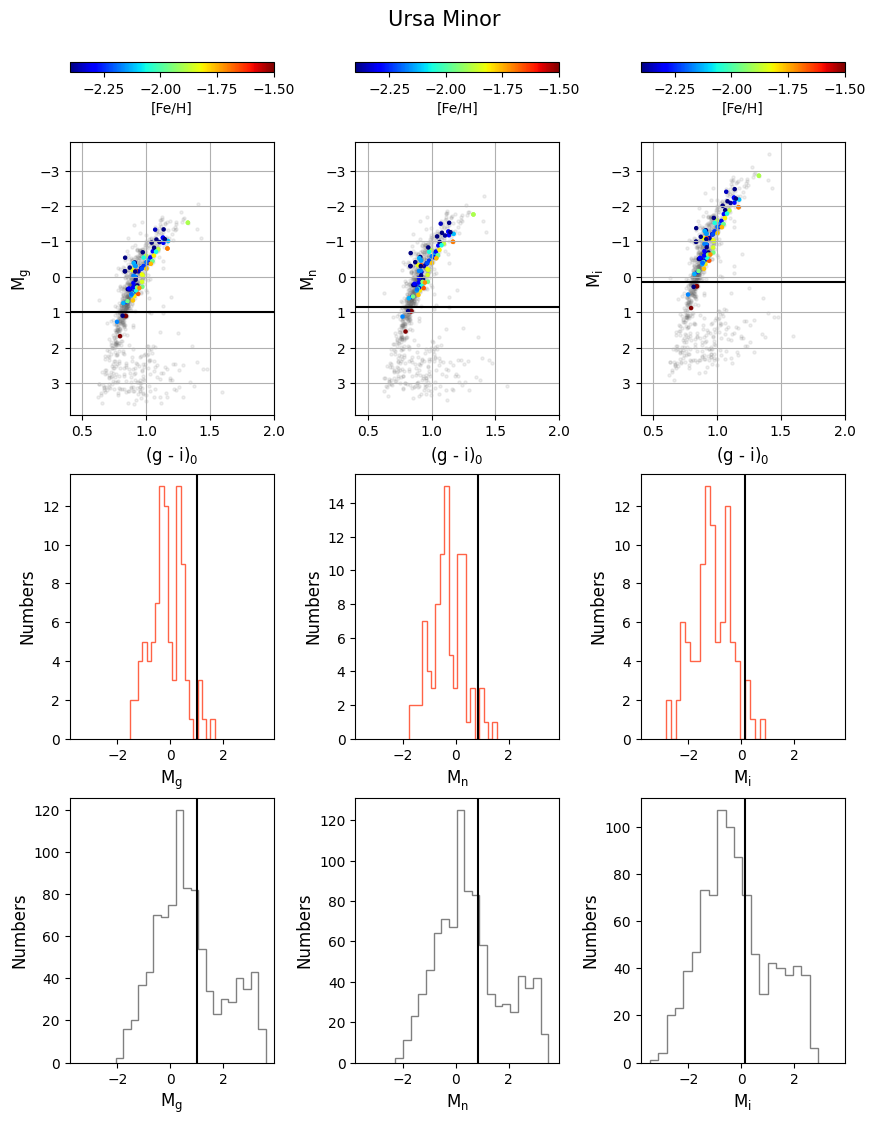

In [18]:
# Ursa Minor

#umi_g0_i0 = umi['g0']-umi['i0']
#print(min(umi_g0_i0))
#umi_g0_sorted = umi.sort_values(by='g0', ascending=False).head(40)
#umi_n0_sorted = umi.sort_values(by='n0', ascending=False).head(40)
#umi_i0_sorted = umi.sort_values(by='i0', ascending=False).head(40)
#result = umi_g0_sorted[['g0']].reset_index(drop=True)
#result['n0'] = umi_n0_sorted['n0'].reset_index(drop=True)
#result['i0'] = umi_i0_sorted['i0'].reset_index(drop=True)
#print(result)

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5), (ax6, ax7, ax8)) = plt.subplots(nrows=3, ncols=3, figsize=(10,13), gridspec_kw={'wspace':0.4, 'height_ratios': [1, 0.75, 0.75]})
ymin = -3.8 ; ymax = 3.9 ; s=5
fig.suptitle('Ursa Minor', size=15, y=0.92)

ax0.scatter(hsc_umi['g0'] - hsc_umi['i0'], hsc_umi['g0'], marker='o', s=s, color='dimgray', alpha=0.1)
im = ax0.scatter(umi['g0'] - umi['i0'], umi['g0'], marker='o', s=s, c=umi['FEH'], cmap='jet', vmin=-2.4, vmax=-1.5)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('(g - i)$_{0}$', size=12)
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
g0_max = 1.00
ax0.axhline(g0_max, 0, 1, color='k')
ax0.grid()
divider = make_axes_locatable(ax0)
cax = divider.new_vertical(size = '4%', pad = 0.7)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('[Fe/H]')

ax1.scatter(hsc_umi['g0'] - hsc_umi['i0'], hsc_umi['n0'], marker='o', s=s, color='dimgray', alpha=0.1)
im = ax1.scatter(umi['g0'] - umi['i0'], umi['n0'], marker='o', s=s, c=umi['FEH'], cmap='jet', vmin=-2.4, vmax=-1.5)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('(g - i)$_{0}$', size=12)
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
n0_max = 0.85
ax1.axhline(n0_max, 0, 1, color='k')
ax1.grid()
divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size = '4%', pad = 0.7)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('[Fe/H]')

ax2.scatter(hsc_umi['g0'] - hsc_umi['i0'], hsc_umi['i0'], marker='o', s=s, color='dimgray', alpha=0.1)
im = ax2.scatter(umi['g0'] - umi['i0'], umi['i0'], marker='o', s=s, c=umi['FEH'], cmap='jet', vmin=-2.4, vmax=-1.5)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('(g - i)$_{0}$', size=12)
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
i0_max = 0.15
ax2.axhline(i0_max, 0, 1, color='k')
ax2.grid()
divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size = '4%', pad = 0.7)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('[Fe/H]')

ax3.hist(umi['g0'], bins=20, histtype='step', linestyle='solid', color='tomato', linewidth=1)
ax3.set_xlabel(r'M$_\mathrm{g}$', size=12)
ax3.set_ylabel('Numbers', size=12)
ax3.set_xlim([ymin, ymax])
ax3.axvline(g0_max, 0, 1, color='k')

ax4.hist(umi['n0'], bins=20, histtype='step', linestyle='solid', color='tomato', linewidth=1)
ax4.set_xlabel(r'M$_\mathrm{n}$', size=12)
ax4.set_ylabel('Numbers', size=12)
ax4.set_xlim([ymin, ymax])
ax4.axvline(n0_max, 0, 1, color='k')

ax5.hist(umi['i0'], bins=20, histtype='step', linestyle='solid', color='tomato', linewidth=1)
ax5.set_xlabel(r'M$_\mathrm{i}$', size=12)
ax5.set_ylabel('Numbers', size=12)
ax5.set_xlim([ymin, ymax])
ax5.axvline(i0_max, 0, 1, color='k')

ax6.hist(hsc_umi['g0'], bins=20, histtype='step', linestyle='solid', color='gray', linewidth=1)
ax6.set_xlabel(r'M$_\mathrm{g}$', size=12)
ax6.set_ylabel('Numbers', size=12)
ax6.set_ylabel('Numbers', size=12)
ax6.set_xlim([ymin, ymax])
ax6.axvline(g0_max, 0, 1, color='k')

ax7.hist(hsc_umi['n0'], bins=20, histtype='step', linestyle='solid', color='gray', linewidth=1)
ax7.set_xlabel(r'M$_\mathrm{n}$', size=12)
ax7.set_ylabel('Numbers', size=12)
ax7.set_xlim([ymin, ymax])
ax7.axvline(n0_max, 0, 1, color='k')

ax8.hist(hsc_umi['i0'], bins=20, histtype='step', linestyle='solid', color='gray', linewidth=1)
ax8.set_xlabel(r'M$_\mathrm{i}$', size=12)
ax8.set_ylabel('Numbers', size=12)
ax8.set_xlim([ymin, ymax])
ax8.axvline(i0_max, 0, 1, color='k')

plt.savefig('Ursaminor_HSC_DEIMOS_mag_cut_maghisto.png', bbox_inches='tight')

# Cut the mag ragnes #DEIMOS 범위에 맞게 HSC를 다 cut하기. It's for more solid results
xmin, xmax = 0.4, 2
g0_max = 1.00 ; n0_max = 0.85 ; i0_max = 0.15
umi_mag = umi[(xmin < umi['g0']-umi['i0']) & (umi['g0']-umi['i0'] < xmax) & (umi['g0'] < g0_max) & (umi['n0'] < n0_max) & (umi['i0'] < i0_max)]
print('len(umi_mag) =', len(umi), '->', len(umi_mag)) #93 -> 88
hsc_umi_mag = hsc_umi[(xmin < hsc_umi['g0']-hsc_umi['i0']) & (hsc_umi['g0']-hsc_umi['i0'] < xmax) & (hsc_umi['g0'] < g0_max) & (hsc_umi['n0'] < n0_max) & (hsc_umi['i0'] < i0_max)]
print('len(hsc_umi_mag) =', len(hsc_umi), '->', len(hsc_umi_mag)) #921 -> 593

len(dra_mag) = 93 -> 90
len(hsc_dra_mag) = 478 -> 342


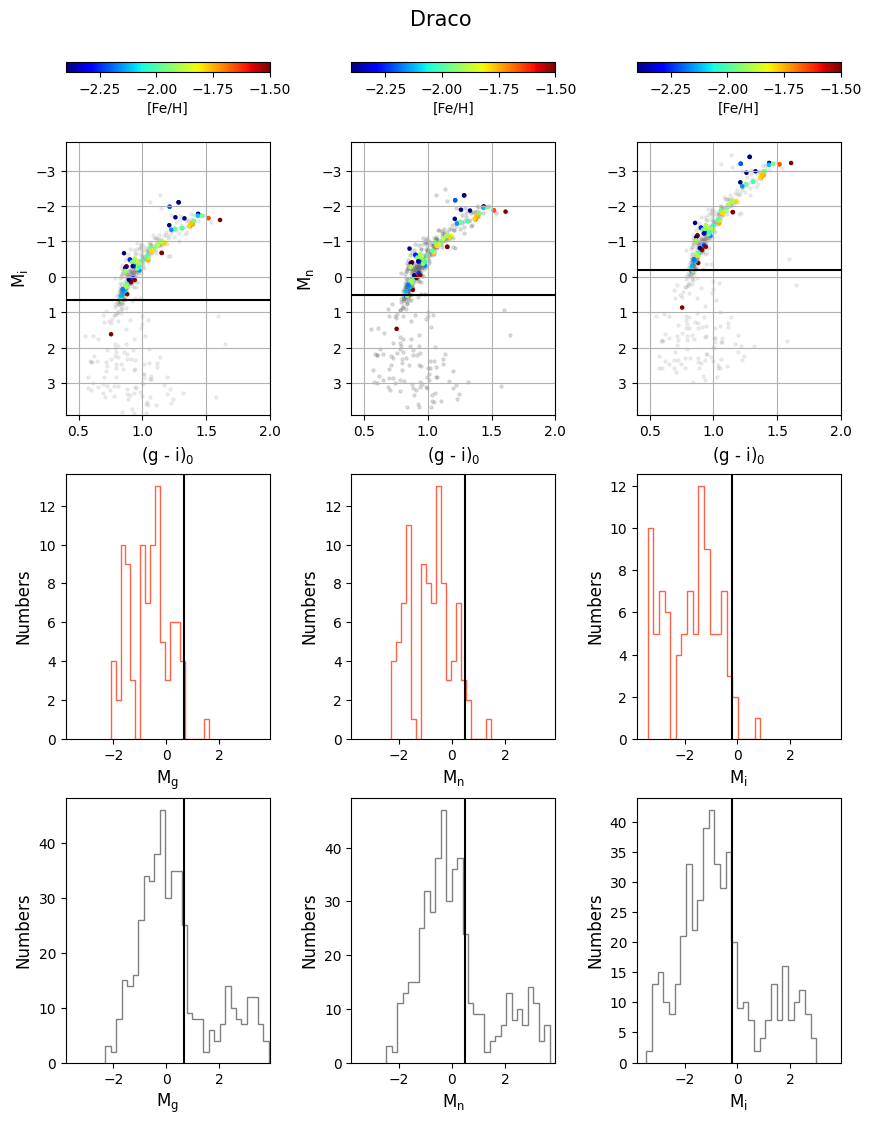

In [19]:
# Draco

#dra_g0_i0 = dra['g0']-dra['i0']
#print(min(dra_g0_i0))
#dra_g0_sorted = dra.sort_values(by='g0', ascending=False).head(40)
#dra_n0_sorted = dra.sort_values(by='n0', ascending=False).head(40)
#dra_i0_sorted = dra.sort_values(by='i0', ascending=False).head(40)
#result = dra_g0_sorted[['g0']].reset_index(drop=True)
#result['n0'] = dra_n0_sorted['n0'].reset_index(drop=True)
#result['i0'] = dra_i0_sorted['i0'].reset_index(drop=True)
#print(result)

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5), (ax6, ax7, ax8)) = plt.subplots(nrows=3, ncols=3, figsize=(10,13), gridspec_kw={'wspace':0.4, 'height_ratios': [1, 0.75, 0.75]})
ymin = -3.8 ; ymax = 3.9 ; s=5
fig.suptitle('Draco', size=15, y=0.92)

ax0.scatter(hsc_dra['g0'] - hsc_dra['i0'], hsc_dra['g0'], marker='o', s=s, color='dimgray', alpha=0.1)
im = ax0.scatter(dra['g0'] - dra['i0'], dra['g0'], marker='o', s=s, c=dra['FEH'], cmap='jet', vmin=-2.4, vmax=-1.5)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('(g - i)$_{0}$', size=12)
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
g0_max = 0.65
ax0.axhline(g0_max, 0, 1, color='k')
ax0.grid()
divider = make_axes_locatable(ax0)
cax = divider.new_vertical(size = '4%', pad = 0.7)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('[Fe/H]')

ax1.scatter(hsc_dra['g0'] - hsc_dra['i0'], hsc_dra['n0'], marker='o', s=s, color='dimgray', alpha=0.1)
ax1.scatter(hsc_dra['g0'] - hsc_dra['i0'], hsc_dra['n0'], marker='o', s=s, color='dimgray', alpha=0.1)
im = ax1.scatter(dra['g0'] - dra['i0'], dra['n0'], marker='o', s=s, c=dra['FEH'], cmap='jet', vmin=-2.4, vmax=-1.5)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('(g - i)$_{0}$', size=12)
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
n0_max = 0.50
ax1.axhline(n0_max, 0, 1, color='k')
ax1.grid()
divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size = '4%', pad = 0.7)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('[Fe/H]')

ax2.scatter(hsc_dra['g0'] - hsc_dra['i0'], hsc_dra['i0'], marker='o', s=s, color='dimgray', alpha=0.1)
im = ax2.scatter(dra['g0'] - dra['i0'], dra['i0'], marker='o', s=s, c=dra['FEH'], cmap='jet', vmin=-2.4, vmax=-1.5)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('(g - i)$_{0}$', size=12)
ax0.set_ylabel(r'M$_\mathrm{i}$', size=12)
i0_max = -0.20
ax2.axhline(i0_max, 0, 1, color='k')
ax2.grid()
divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size = '4%', pad = 0.7)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('[Fe/H]')

ax3.hist(dra['g0'], bins=20, histtype='step', linestyle='solid', color='tomato', linewidth=1)
ax3.set_xlabel(r'M$_\mathrm{g}$', size=12)
ax3.set_ylabel('Numbers', size=12)
ax3.set_xlim([ymin, ymax])
ax3.axvline(g0_max, 0, 1, color='k')

ax4.hist(dra['n0'], bins=20, histtype='step', linestyle='solid', color='tomato', linewidth=1)
ax4.set_xlabel(r'M$_\mathrm{n}$', size=12)
ax4.set_ylabel('Numbers', size=12)
ax4.set_xlim([ymin, ymax])
ax4.axvline(n0_max, 0, 1, color='k')

ax5.hist(dra['i0'], bins=20, histtype='step', linestyle='solid', color='tomato', linewidth=1)
ax5.set_xlabel(r'M$_\mathrm{i}$', size=12)
ax5.set_ylabel('Numbers', size=12)
ax5.set_xlim([ymin, ymax])
ax5.axvline(i0_max, 0, 1, color='k')

ax6.hist(hsc_dra['g0'], bins=30, histtype='step', linestyle='solid', color='gray', linewidth=1)
ax6.set_xlabel(r'M$_\mathrm{g}$', size=12)
ax6.set_ylabel('Numbers', size=12)
ax6.set_ylabel('Numbers', size=12)
ax6.set_xlim([ymin, ymax])
ax6.axvline(g0_max, 0, 1, color='k')

ax7.hist(hsc_dra['n0'], bins=30, histtype='step', linestyle='solid', color='gray', linewidth=1)
ax7.set_xlabel(r'M$_\mathrm{n}$', size=12)
ax7.set_ylabel('Numbers', size=12)
ax7.set_xlim([ymin, ymax])
ax7.axvline(n0_max, 0, 1, color='k')

ax8.hist(hsc_dra['i0'], bins=30, histtype='step', linestyle='solid', color='gray', linewidth=1)
ax8.set_xlabel(r'M$_\mathrm{i}$', size=12)
ax8.set_ylabel('Numbers', size=12)
ax8.set_xlim([ymin, ymax])
ax8.axvline(i0_max, 0, 1, color='k')

plt.savefig('Draco_HSC_DEIMOS_mag_cut_maghisto.png', bbox_inches='tight')

# Cut the mag ragnes #DEIMOS 범위에 맞게 HSC를 다 cut하기. It's for more solid results
xmin, xmax = 0.4, 2
g0_max = 0.65 ; n0_max = 0.50 ; i0_max = -0.20
dra_mag = dra[(xmin < dra['g0']-dra['i0']) & (dra['g0']-dra['i0'] < xmax) & (dra['g0'] < g0_max) & (dra['n0'] < n0_max) & (dra['i0'] < i0_max)]
print('len(dra_mag) =', len(dra), '->', len(dra_mag)) #93 -> 90
hsc_dra_mag = hsc_dra[(xmin < hsc_dra['g0']-hsc_dra['i0']) & (hsc_dra['g0']-hsc_dra['i0'] < xmax) & (hsc_dra['g0'] < g0_max) & (hsc_dra['n0'] < n0_max) & (hsc_dra['i0'] < i0_max)]
print('len(hsc_dra_mag) =', len(hsc_dra), '->', len(hsc_dra_mag)) #478 -> 342

In [20]:
# Combine *_mag (DEIMOS) and hsc_*_mag (HSC)
frame = [fnx_mag, scl_mag, umi_mag, dra_mag]
df_mag = pd.concat(frame, ignore_index=True)
print('len(df_mag) =', len(df_mag)) #741
print(Counter(df_mag['DSPH'])) #Counter({'for': 283, 'scl': 280, 'dra': 90, 'umi': 88})

len(df_mag) = 741
Counter({'for': 283, 'scl': 280, 'dra': 90, 'umi': 88})
